In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

housing = pd.read_csv('../data/housing.csv')

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [91]:
len(housing)

20640

In [3]:
X = housing.drop("median_house_value", axis=1)
y = np.array(housing["median_house_value"])

In [4]:
#apply OHE to ocean_proximity column
X_enc = pd.get_dummies(X, columns=["ocean_proximity"])

#Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_enc)
X_enc = imputer.transform(X_enc)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2)
mlp = MLPRegressor(hidden_layer_sizes=(5), max_iter=1000)
mlp2 = MLPRegressor(hidden_layer_sizes=(15), max_iter=1000)

In [6]:
mlp.fit(X_train, y_train)
mlp2.fit(X_train, y_train)

c:\Users\leonw\anaconda3\envs\capstone_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leonw\anaconda3\envs\capstone_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=15, max_iter=1000)

In [8]:
#Test error
print(mean_squared_error(y_test, mlp.predict(X_test)))
print(mean_squared_error(y_test, mlp2.predict(X_test)))

10214715040.320763
9479459735.048225


In [39]:
#Train error
mean_squared_error(y_train, mlp.predict(X_train))

4220246032.0314903

In [40]:
#Baseline error
mean_squared_error(np.mean(y_train)*np.ones(len(y_test)), y_test)

13412603787.759983

In [41]:
mlp.predict(X_test)

array([159932.25245589, 111513.4017089 , 375868.59874881, ...,
       145611.38776664, 281493.3777842 ,  66674.60962033])

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu
import pandas as pd
from tqdm import tqdm
from deepsig import aso, bootstrap_test, permutation_test
from random import sample
import random
CONSIDERED_TESTS = {
    "ASO": lambda a, b: aso(a, b, show_progress=False),
    "Student's t": lambda a, b: ttest_ind(a, b, equal_var=False, alternative="greater")[
        1
    ],
    "Bootstrap": lambda a, b: bootstrap_test(a, b),
    "Permutation": lambda a, b: permutation_test(a, b),
    "Wilcoxon": lambda a, b: wilcoxon(a, b, alternative="greater").pvalue,
    "Mann-Whitney U": lambda a, b: mannwhitneyu(a, b, alternative="greater").pvalue,
    }

SAMPLE_SIZES = [5, 10, 15, 20]

In [5]:
def get_subsample(full_data_X, full_data_y):
    #Takes in full data, returns subsampled train and validate sets
    subsample_indices = random.sample(range(len(full_data_y)), k=round(0.1 * len(full_data_y)))
    subsample_X = full_data_X[subsample_indices]
    subsample_y = full_data_y[subsample_indices]
    subsample_train_X, subsample_valid_X, subsample_train_y, subsample_valid_y = train_test_split(subsample_X, subsample_y, test_size=0.2)
    return subsample_train_X, subsample_train_y, subsample_valid_X, subsample_valid_y

In [6]:
def bootstrap_scores(model1, model2, subsample_train_X, subsample_train_y, subsample_valid_X, subsample_valid_y):
    #Takes in models and data, performs 40 bootstrap samples (20 for each model)
    #Returns two lists of scores (list of list)
    scores1 = []
    for i in range(0,20):
        bootstrap_indices = random.choices(range(len(subsample_train_X)), k=len(subsample_train_X))
        boot_X = subsample_train_X[bootstrap_indices]
        boot_y = subsample_train_y[bootstrap_indices]
        model1.fit(boot_X, boot_y)
        score = mean_squared_error(subsample_valid_y, model1.predict(subsample_valid_X))
        scores1.append(score)
    scores2 = []
    for i in range(0,20):
        bootstrap_indices = random.choices(range(len(subsample_train_X)), k=len(subsample_train_X))
        boot_X = subsample_train_X[bootstrap_indices]
        boot_y = subsample_train_y[bootstrap_indices]
        model2.fit(boot_X, boot_y)
        score = mean_squared_error(subsample_valid_y, model2.predict(subsample_valid_X))
        scores2.append(score)
    scores = [scores1, scores2]
    return scores

In [7]:
def compute_stats(scores, stats_dict):
    #Takes in sets of scores, performs various statistical testing 
    #Output is 2d array, type of test on one axis and sample size on the other
    for samp_size in SAMPLE_SIZES:
        scores1 = sample(scores[0],samp_size)
        scores2 = sample(scores[1],samp_size)
        samp_size_scores = []
        iter = 0
        for key in CONSIDERED_TESTS:
            pval = CONSIDERED_TESTS[key](scores1, scores2)
            stats_dict[samp_size][iter].append(pval)
            iter += 1
        
    return stats_dict

In [8]:
def make_statistics(nloops, model1, model2, full_data_X, full_data_y):
    #full_data_X and full_data_y must be two numpy arrays
    stats_dict = {
    5: [[], [], [], [], [], []],
    10: [[], [], [], [], [], []],
    15: [[], [], [], [], [], []],
    20: [[], [], [], [], [], []]
    }
    for i in range(0,nloops):
        subsample_train_X, subsample_train_y, subsample_valid_X, subsample_valid_y = get_subsample(full_data_X, full_data_y)
        scores = bootstrap_scores(model1, model2, subsample_train_X, subsample_train_y, subsample_valid_X, subsample_valid_y)
        stats_dict = compute_stats(scores, stats_dict)
    return(stats_dict)

In [39]:
model1 = MLPRegressor(hidden_layer_sizes=(5,5), max_iter=1000)
model2 = MLPRegressor(hidden_layer_sizes=(5), max_iter=1000)

In [16]:
#Test with two iterations
mlp_diff_model_output = make_statistics(100,mlp,mlp2,X_enc,y)

C:\Users\Spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Spen

In [17]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(mlp_diff_model_output, 'mlp_diff_model_output.pkl')


In [18]:
mlp_diff_model_output

{5: [[0.0,
   0.009197084127411012,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.00016900493832495959,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0055291623675864845,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0031784561237277148,
   4.066964173647435e-05,
   0.0,
   0.0],
  [2.4351863315605735e-05,
   0.002364260625568572,
   0.0016894010920732781,
   1.553404072800551e-05,
  

# MAKE PLOTS

In [27]:
def plot_type1error(stats, plot_title):    
    type1error_dict = {
        5: [],
        10: [],
        15: [],
        20: []
    }

    num_trials = len(stats[5][0])

    for key in stats.keys():
        for j in range(0, 6):
            count = 0
            for k in range(0, num_trials):
                if j == 0:
                    if stats[key][j][k] < 0.2:
                        count += 1
                else:
                    if stats[key][j][k] < 0.05:
                        count += 1

            type1error_dict[key].append(count/num_trials)

    #restructure data for line plotting
    type1error_dict = pd.DataFrame(type1error_dict)
    type1error_dict = type1error_dict.transpose()
    type1error_dict.columns = ["ASO", "Student's t", "Bootstrap", "Permutation", "Wilcoxon", "Mann-Whitney U"]
    type1error_dict = type1error_dict.reset_index()
    type1error_dict = type1error_dict.rename(columns = {"index": "Sample Size"})
    type1error_dict = type1error_dict.melt(id_vars = ["Sample Size"], var_name = "Test", value_name = "Type 1 Error Rate")
    
    #plot type 1 error rate
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    ax = sns.lineplot(x="Sample Size", y="Type 1 Error Rate", hue="Test", data=type1error_dict)
    ax.set_title(plot_title)
    ax.set(xlabel='Sample Size', ylabel='Type 1 Error Rate')
    plt.savefig("type1error_mixture.png")

In [31]:
def plot_type2error(stats, plot_title):    
    type2error_dict = {
        5: [],
        10: [],
        15: [],
        20: []
    }

    num_trials = len(stats[5][0])

    for key in stats.keys():
        for j in range(0, 6):
            count = 0
            for k in range(0, num_trials):
                if j == 0:
                    if stats[key][j][k] > 0.2:
                        count += 1
                else:
                    if stats[key][j][k] > 0.05:
                        count += 1

            type2error_dict[key].append(count/num_trials)

    #restructure data for line plotting
    type2error_dict = pd.DataFrame(type2error_dict)
    type2error_dict = type2error_dict.transpose()
    type2error_dict.columns = ["ASO", "Student's t", "Bootstrap", "Permutation", "Wilcoxon", "Mann-Whitney U"]
    type2error_dict = type2error_dict.reset_index()
    type2error_dict = type2error_dict.rename(columns = {"index": "Sample Size"})
    type2error_dict = type2error_dict.melt(id_vars = ["Sample Size"], var_name = "Test", value_name = "Type 1 Error Rate")
    
    #plot type 1 error rate
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    ax = sns.lineplot(x="Sample Size", y="Type 1 Error Rate", hue="Test", data=type2error_dict)
    ax.set_title(plot_title)
    ax.set(xlabel='Sample Size', ylabel='Type 1 Error Rate')
    plt.savefig("type1error_mixture.png")

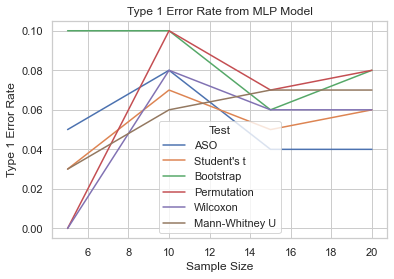

In [32]:
plot_type1error(mlp_same_model_output, "Type 1 Error Rate from MLP Model")

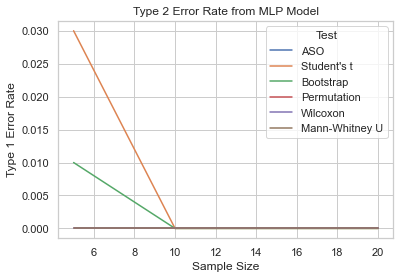

In [33]:
plot_type2error(mlp_diff_model_output, "Type 2 Error Rate from MLP Model")

In [30]:
mlp_diff_model_output

{5: [[0.0,
   0.009197084127411012,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.00016900493832495959,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0055291623675864845,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0031784561237277148,
   4.066964173647435e-05,
   0.0,
   0.0],
  [2.4351863315605735e-05,
   0.002364260625568572,
   0.0016894010920732781,
   1.553404072800551e-05,
  